- **Author**: jaehyuk Heo
- **Paper**: Exploring Simple Siamese Representation Learning [ [pdf](https://arxiv.org/pdf/2011.10566.pdf) ]
    - CVPR 2021, Best Paper Honorable Mentions
- **Official github (Pytorch)**: https://github.com/facebookresearch/simsiam


**Contribution**

- 기존 Siamese Network의 문제점으로 loss가 0이 되어 학습이 잘된것 처럼 보이지만 실제로는 학습이 잘 되지 않는 `collapsing` 문제를 `stop gradients`로 해결함


<p align='center'>
    <img width='500' src='https://user-images.githubusercontent.com/37654013/147898873-bca2c8e8-573b-4c37-91bc-d2b248197ada.png'>
</p>



**Experiments**

<p align='center'>
    <img width='800' src='https://user-images.githubusercontent.com/37654013/147920597-3860c766-1758-479c-ad4e-9cbe70b3f5ad.png'>
</p>


<p align='center'>
    <img width='800' src='https://user-images.githubusercontent.com/37654013/147922174-752081ec-9aa0-4191-bd0d-8020ea48d9e8.png'>
</p>

In [1]:
import torch
import torch.nn as nn

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models 

from torchvision.utils import make_grid

import matplotlib.pyplot as plt

from PIL import ImageFilter
import random
import time
import math
from tqdm.auto import tqdm

from utils import AverageMeter, ProgressMeter, \
                  accuracy, train, validate, run, \
                  adjust_learning_rate, load_pretrained

In [65]:
class Config:
    image_size = 32
    datadir = '/datasets/CIFAR10'
    epochs = 100
    fine_epochs = 30
    batch_size = 512
    num_workers = 4
    
    dim = 2048
    pred_dim = 512
    
    # paper settings
    lr = 0.03
    fine_lr = 0.1
    momentum = 0.9
    weight_decay = 0.0005
    fine_weight_decay = 0

args = Config()

init_lr = args.lr * args.batch_size / 256
fine_init_lr = args.fine_lr * args.batch_size / 256

# Data Loader

In [3]:
class TwoCropsTransform:
    """Take two random crops of one image as the query and key."""

    def __init__(self, base_transform):
        self.base_transform = base_transform

    def __call__(self, x):
        q = self.base_transform(x)
        k = self.base_transform(x)
        return [q, k]

In [4]:
# Data loading code
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# MoCo v2's aug: similar to SimCLR https://arxiv.org/abs/2002.05709
augmentation = [
    transforms.RandomApply([
        transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)  # not strengthened
    ], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
]

train_dataset = datasets.CIFAR10(
    root=args.datadir,
    transform=TwoCropsTransform(transforms.Compose(augmentation)))


In [5]:
train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=args.batch_size, shuffle=True,
        num_workers=args.num_workers, pin_memory=True, drop_last=True)

In [6]:
images, _ = next(iter(train_loader))

In [7]:
images[0].shape

torch.Size([512, 3, 32, 32])

In [8]:
images[1].shape

torch.Size([512, 3, 32, 32])

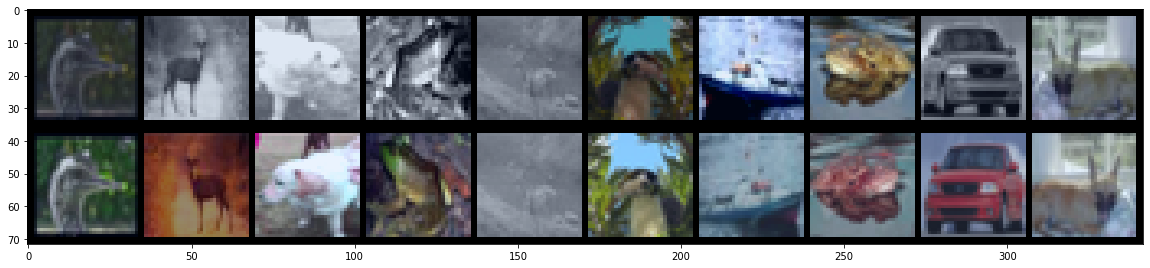

In [9]:
plt.figure(figsize=(20,10))
plt.imshow(
    torch.vstack([
        make_grid(images[0][:10], nrow=10, normalize=True).permute(1,2,0),
        make_grid(images[1][:10], nrow=10, normalize=True).permute(1,2,0)
    ])
)

# Build a Model

In [10]:
class SimSiam(nn.Module):
    """
    Build a SimSiam model.a
    """
    def __init__(self, base_encoder, dim=2048, pred_dim=512):
        """
        dim: feature dimension (default: 2048)
        pred_dim: hidden dimension of the predictor (default: 512)
        """
        super(SimSiam, self).__init__()

        # create the encoder
        # num_classes is the output fc dimension, zero-initialize last BNs
        self.encoder = base_encoder(num_classes=dim, zero_init_residual=True)

        # build a 3-layer projector
        prev_dim = self.encoder.fc.weight.shape[1]
        self.encoder.fc = nn.Sequential(nn.Linear(prev_dim, prev_dim, bias=False),
                                        nn.BatchNorm1d(prev_dim),
                                        nn.ReLU(inplace=True), # first layer
                                        nn.Linear(prev_dim, prev_dim, bias=False),
                                        nn.BatchNorm1d(prev_dim),
                                        nn.ReLU(inplace=True), # second layer
                                        self.encoder.fc,
                                        nn.BatchNorm1d(dim, affine=False)) # output layer
        self.encoder.fc[6].bias.requires_grad = False # hack: not use bias as it is followed by BN

        # build a 2-layer predictor
        self.predictor = nn.Sequential(nn.Linear(dim, pred_dim, bias=False),
                                        nn.BatchNorm1d(pred_dim),
                                        nn.ReLU(inplace=True), # hidden layer
                                        nn.Linear(pred_dim, dim)) # output layer

    def forward(self, x1, x2):
        """
        Input:
            x1: first views of images
            x2: second views of images
        Output:
            p1, p2, z1, z2: predictors and targets of the network
            See Sec. 3 of https://arxiv.org/abs/2011.10566 for detailed notations
        """

        # compute features for one view
        z1 = self.encoder(x1) # NxC
        z2 = self.encoder(x2) # NxC

        p1 = self.predictor(z1) # NxC
        p2 = self.predictor(z2) # NxC

        return p1, p2, z1.detach(), z2.detach()

In [11]:
model = SimSiam(
    models.resnet18,
    args.dim, args.pred_dim
)
model.cuda()
print('architecture -> resnet18')

architecture -> resnet18


# Self-Training

**Argorithm 1:** SimSiam Pseudocode, Pytorch-like

---
```{python}
# f: backbone + projection mlp
# h: prediction mlp
for x in loader: # load a minibatch x with n samples
    x1, x2 = aug(x), aug(x) # random augmentation
    z1, z2 = f(x1), f(x2) # projections, n-by-d
    p1, p2 = h(z1), h(z2) # predictions, n-by-d
    L = D(p1, z2)/2 + D(p2, z1)/2 # loss
    L.backward() # back-propagate
    update(f, h) # SGD update
    
def D(p, z): # negative cosine similarity
    z = z.detach() # stop gradient
    p = normalize(p, dim=1) # l2-normalize
    z = normalize(z, dim=1) # l2-normalize
    return -(p*z).sum(dim=1).mean()
```
---

In [12]:
def self_train(train_loader, model, criterion, optimizer, epoch, args):
    batch_time = AverageMeter('Time', ':6.3f')
    data_time = AverageMeter('Data', ':6.3f')
    losses = AverageMeter('Loss', ':.4f')
    
    progress = ProgressMeter(
        len(train_loader),
        [batch_time, data_time, losses],
        prefix="Epoch: [{}]".format(epoch))

    # switch to train mode
    model.train()

    end = time.time()
    for i, (images, _) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)

        images[0] = images[0].cuda()
        images[1] = images[1].cuda()

        # compute output and loss
        p1, p2, z1, z2 = model(x1=images[0], x2=images[1])
        loss = -(criterion(p1, z2).mean() + criterion(p2, z1).mean()) * 0.5

        losses.update(loss.item(), images[0].size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
            
    return losses.avg

In [13]:
optim_params = [{'params': model.encoder.parameters(), 'fix_lr': False},
                {'params': model.predictor.parameters(), 'fix_lr': True}]

# infer learning rate before changing batch size
init_lr = args.lr * args.batch_size / 256
    
optimizer = torch.optim.SGD(optim_params, lr=init_lr, momentum=args.momentum, weight_decay=args.weight_decay)
criterion = nn.CosineSimilarity(dim=1).cuda()

self_train_losses = []
for epoch in tqdm(range(args.epochs), leave=True):
    adjust_learning_rate(optimizer, init_lr, epoch, args)
    
    # train for one epoch
    loss = self_train(train_loader, model, criterion, optimizer, epoch, args)
    self_train_losses.append(loss)
    
torch.save({
    'epoch': epoch + 1,
    'arch': 'resnet18',
    'state_dict': model.state_dict(),
    'optimizer' : optimizer.state_dict(),
}, 'checkpoint_{:04d}.pth.tar'.format(epoch))


# Fine-tuning

## Load DataLoaders

In [66]:
# Data loading code
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(
    root = args.datadir,
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize,
    ])), 
    batch_size=args.batch_size, shuffle=True,
    num_workers=args.num_workers, pin_memory=True)

valid_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(
        root = args.datadir,
        train = False,
        transform = transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ])),
    batch_size=512, shuffle=False,
    num_workers=args.num_workers, pin_memory=True)

## Build a Model

In [67]:
model = models.resnet18(num_classes=10)

# freeze all layers but the last fc
for name, param in model.named_parameters():
    if name not in ['fc.weight', 'fc.bias']:
        param.requires_grad = False
# init the fc layer
model.fc.weight.data.normal_(mean=0.0, std=0.01)
model.fc.bias.data.zero_()
print('build a model')

build a model


## Load weights

In [68]:
pretrained_path = 'checkpoint_{:04d}.pth.tar'.format(args.epochs-1)
model = load_pretrained(model, pretrained_path)

=> loading checkpoint 'checkpoint_0099.pth.tar'
=> loaded pre-trained model 'checkpoint_0099.pth.tar'


## Training

In [69]:
# optimize only the linear classifier
parameters = list(filter(lambda p: p.requires_grad, model.parameters()))
assert len(parameters) == 2  # fc.weight, fc.bias

optimizer = torch.optim.SGD(parameters, lr=fine_init_lr, momentum=args.momentum, weight_decay=args.fine_weight_decay)
criterion = nn.CrossEntropyLoss().cuda()

fine = run(
    args, 
    args.fine_epochs, 
    train_loader, 
    valid_loader,
    model,
    optimizer,
    criterion,
    init_lr,
    savename='model_best_finetuning',
    sanity_check=True,
    pretrained_path=pretrained_path)

 * Acc@1 33.430 Acc@5 83.200
 * Acc@1 34.180 Acc@5 84.450
 * Acc@1 35.310 Acc@5 84.640
 * Acc@1 35.880 Acc@5 85.260
 * Acc@1 36.180 Acc@5 85.430
 * Acc@1 36.550 Acc@5 85.660
 * Acc@1 36.770 Acc@5 85.810
 * Acc@1 36.930 Acc@5 85.980
 * Acc@1 36.700 Acc@5 86.000
 * Acc@1 36.920 Acc@5 86.390
 * Acc@1 37.270 Acc@5 86.460
 * Acc@1 37.300 Acc@5 86.470
 * Acc@1 37.460 Acc@5 86.300
 * Acc@1 37.610 Acc@5 86.500
 * Acc@1 37.580 Acc@5 86.560
 * Acc@1 37.810 Acc@5 86.570
 * Acc@1 37.980 Acc@5 86.670
 * Acc@1 38.280 Acc@5 86.750
 * Acc@1 38.240 Acc@5 86.810
 * Acc@1 37.760 Acc@5 86.640
 * Acc@1 38.510 Acc@5 86.810
 * Acc@1 38.410 Acc@5 87.090
 * Acc@1 38.250 Acc@5 86.770
 * Acc@1 38.490 Acc@5 86.840
 * Acc@1 38.190 Acc@5 86.890
 * Acc@1 38.250 Acc@5 86.880
 * Acc@1 38.580 Acc@5 86.890
 * Acc@1 38.800 Acc@5 86.920
 * Acc@1 38.480 Acc@5 87.040
 * Acc@1 38.810 Acc@5 86.950


# Comparison

## From scratch (FCN)

In [70]:
model = models.resnet18(num_classes=10)
model.cuda()
# freeze all layers but the last fc
for name, param in model.named_parameters():
    if name not in ['fc.weight', 'fc.bias']:
        param.requires_grad = False
# init the fc layer
model.fc.weight.data.normal_(mean=0.0, std=0.01)
model.fc.bias.data.zero_()
print('build a model')

parameters = list(filter(lambda p: p.requires_grad, model.parameters()))
assert len(parameters) == 2  # fc.weight, fc.bias

optimizer = torch.optim.SGD(parameters, lr=fine_init_lr, momentum=args.momentum, weight_decay=args.fine_weight_decay)

scratch_fcn = run(
    args, 
    args.fine_epochs, 
    train_loader, 
    valid_loader,
    model,
    optimizer,
    criterion,
    init_lr,
    savename='model_best_scratch_fcn')

build a model


 * Acc@1 25.080 Acc@5 60.390
 * Acc@1 34.990 Acc@5 83.450
 * Acc@1 33.480 Acc@5 81.170
 * Acc@1 36.580 Acc@5 83.070
 * Acc@1 36.510 Acc@5 85.710
 * Acc@1 38.390 Acc@5 85.590
 * Acc@1 36.820 Acc@5 86.240
 * Acc@1 39.390 Acc@5 86.750
 * Acc@1 37.360 Acc@5 86.300
 * Acc@1 41.160 Acc@5 87.150
 * Acc@1 40.500 Acc@5 87.120
 * Acc@1 40.310 Acc@5 87.220
 * Acc@1 39.470 Acc@5 87.330
 * Acc@1 39.230 Acc@5 87.570
 * Acc@1 42.180 Acc@5 87.760
 * Acc@1 41.250 Acc@5 87.450
 * Acc@1 39.420 Acc@5 87.030
 * Acc@1 40.100 Acc@5 86.760
 * Acc@1 41.090 Acc@5 86.490
 * Acc@1 42.270 Acc@5 88.310
 * Acc@1 39.710 Acc@5 87.640
 * Acc@1 42.130 Acc@5 88.100
 * Acc@1 40.410 Acc@5 87.620
 * Acc@1 41.550 Acc@5 87.260
 * Acc@1 41.780 Acc@5 87.980
 * Acc@1 41.880 Acc@5 87.840
 * Acc@1 37.950 Acc@5 87.370
 * Acc@1 42.400 Acc@5 88.350
 * Acc@1 42.040 Acc@5 87.310
 * Acc@1 41.140 Acc@5 87.880


# Results

In [71]:
import matplotlib.pyplot as plt

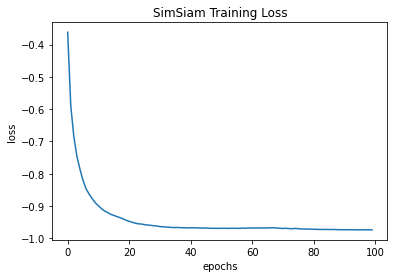

In [74]:
plt.plot(range(args.epochs), self_train_losses)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('SimSiam Training Loss')
plt.show()

Comparison of Linear Classifier Performance


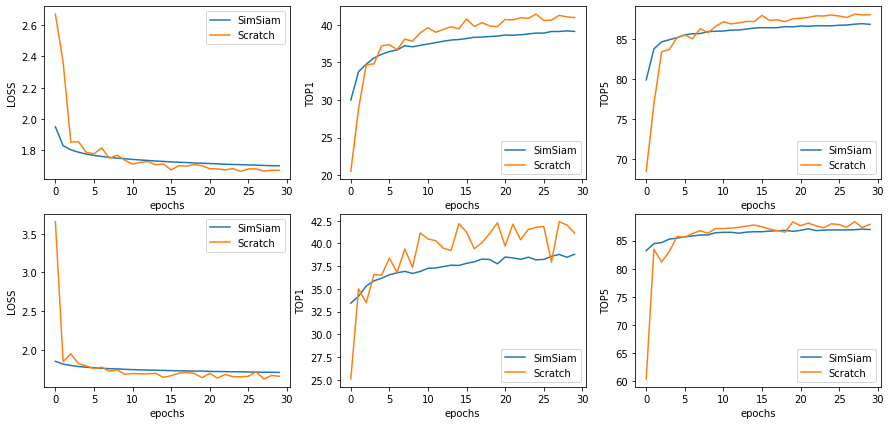

In [89]:
print('Comparison of Linear Classifier Performance')

fig, ax = plt.subplots(2,3, figsize=(15,7))

for r, d in enumerate(['train','valid']):
    for c, m in enumerate(['loss','top1','top5']):
        ax[r,c].plot(range(args.fine_epochs), fine[d][m], label='SimSiam')
        ax[r,c].plot(range(args.fine_epochs), scratch_fcn[d][m], label='Scratch')
        ax[r,c].set_xlabel('epochs')
        ax[r,c].set_ylabel(m.upper())
        ax[r,c].legend()
        

plt.show()

# Save history

In [90]:
import json

In [91]:
json.dump(
    {
        'self-training_loss':self_train_losses,
        'fc_comparison':{
            'simsiam':fine,
            'scratch':scratch_fcn
        }
    },
    open('history.json','w')
)